In [2]:
import numpy as np
import xarray as xr
import glob
from datetime import timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
datadir = 'data/'

north_str = '300S'
dset1 = '_southof%s_swmt_'%north_str
lstr = 'sigma2'
dl = '005'
dset2 = '_moc_rho2_online_lores'
dset3 = '_dVdt_rho2_online_lores'

In [7]:
ddict = {mod:{} for mod in ['CM4','ESM4']}
for mod in ddict:
    ddict_exp = {exp:{} for exp in ['control','antwater','stress','antwaterstress']}
    for exp in ddict_exp:
        if exp == 'control':
            
            for var in ['swmt','psi','Storage change']:
                if var == 'swmt':
                    files = glob.glob(datadir+'%s_piControl'%mod+'_so_*'+dset1+'%s_%s.nc'%(lstr,dl))
                elif var == 'psi':
                    files = glob.glob(datadir+'%s_piControl_global_*'%mod+dset2+'.nc')
                elif var == 'Storage change':
                    files = glob.glob(datadir+'%s_piControl_so_*'%mod+dset3+'.nc')
                    
                if len(files)>1:
                    print('WARNING: More than one file for '+var+' in '+mod+'-'+exp+'. Please specify.')
                    print('Loading '+files[0])
                elif len(files)==0:
                    print('ERROR: No file available for '+var+' in '+mod+'-'+exp)
                    ddict[mod]['dVdt' if var =='Storage change' else var] = []
                    continue
                    
                ddict_exp[exp]['dVdt' if var =='Storage change' else var] = \
                    xr.open_dataset(files[0])[var].sel(time=slice(None,'0650'))
                    
        else:
            ddict_mem = {mem:{} for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201'])}
            for mem in ddict_mem:
                for var in ['swmt','psi','Storage change']:
                    if var == 'swmt':
                        files = glob.glob(datadir+'%s_%s_%s'%(mod,exp,mem)+'_so_*'+dset1+'%s_%s.nc'%(lstr,dl))
                    elif var == 'psi':
                        files = glob.glob(datadir+'%s_%s_%s_global_*'%(mod,exp,mem)+dset2+'.nc')
                    elif var == 'Storage change':
                        files = glob.glob(datadir+'%s_%s_%s_so_*'%(mod,exp,mem)+dset3+'.nc')
                        
                    if len(files)>1:
                        print('WARNING: More than one file for '+var+' in '+mod+'-'+exp+'-'+mem+'. Please specify.')
                        print('Loading '+files[0])
                    elif len(files)==0:
                        print('ERROR: No file available for '+var+' in '+mod+'-'+exp+'-'+mem)
                        ddict_mem[mem]['dVdt' if var =='Storage change' else var] = []
                        continue
                        
                    ddict_mem[mem]['dVdt' if var =='Storage change' else var] = xr.open_dataset(files[0])[var]
            ddict_exp[exp] = ddict_mem
    ddict[mod] = ddict_exp

In [8]:
tsdict = {mod:{} for mod in list(ddict.keys())}
for mod in tsdict:
    tsdict[mod] = {exp:{} for exp in list(ddict[mod].keys())}
    
for mod in tsdict:
    for exp in tsdict[mod]:
        
        if exp=='control':
            smoc = ddict[mod][exp]['psi'].sel(rho2_i=slice(1033,1038),yq=slice(None,0))
            smoc['sigma2'] = smoc.rho2_i-1000
            smoc = smoc.swap_dims({'rho2_i':'sigma2'})
            psi = (-smoc).sel(yq=[-30], method='nearest').squeeze()
            
            dVdt = ddict[mod][exp]['dVdt'].sel(rho2_i=slice(1033,1038))
            dVdt['sigma2'] = dVdt.rho2_i-1000
            dVdt = dVdt.swap_dims({'rho2_i':'sigma2'})
            
            G = ddict[mod][exp]['swmt']*1e-6
            G_interp = G.interp(sigma2=psi.sigma2,kwargs={'fill_value':0}).groupby('time.year').mean('time')
            G_interp = G_interp.rename({'year':'time'}).assign_coords({'time': psi['time']})
            D = dVdt + psi - G_interp
            
            tsdict[mod][exp]['psi'] = psi
            tsdict[mod][exp]['swmt'] = G_interp
            tsdict[mod][exp]['iwmt'] = D
            tsdict[mod][exp]['dVdt'] = dVdt
    
        else:
            psis = []
            dVdts = []
            Gs = []
            for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
                
                smoc = ddict[mod][exp][mem]['psi'].sel(rho2_i=slice(1033,1038),yq=slice(None,0))
                smoc['sigma2'] = smoc.rho2_i-1000
                smoc = smoc.swap_dims({'rho2_i':'sigma2'})
                psi = (-smoc).sel(yq=[-30], method='nearest').squeeze()
                
                dVdt = ddict[mod][exp][mem]['dVdt'].sel(rho2_i=slice(1033,1038))
                dVdt['sigma2'] = dVdt.rho2_i-1000
                dVdt = dVdt.swap_dims({'rho2_i':'sigma2'})
                
                G = ddict[mod][exp][mem]['swmt']*1e-6
                G_interp = G.interp(sigma2=psi.sigma2,kwargs={'fill_value':0}).groupby('time.year').mean('time')
                
                if mem == '101':
                    #print(mod,mem)
                    psi['time'] = psi.time - timedelta(days=365*(int(mem)-1))
                    dVdt['time'] = dVdt.time - timedelta(days=365*(int(mem)-1))
                
                psi = psi.reset_coords(drop=True)
                psi['mem'] = int(mem)
                psis.append(psi)
                
                dVdt = dVdt.reset_coords(drop=True)
                dVdt['mem'] = int(mem)
                dVdts.append(dVdt)
                
                G_interp = G_interp.rename({'year':'time'}).assign_coords({'time': psi['time']})
                G_interp = G_interp.reset_coords(drop=True)
                G_interp['mem'] = int(mem)
                Gs.append(G_interp)
                
            tsdict[mod][exp]['psi'] = xr.concat(psis, dim='mem')
            tsdict[mod][exp]['swmt'] = xr.concat(Gs, dim='mem')
            tsdict[mod][exp]['dVdt'] = xr.concat(dVdts, dim='mem')
            tsdict[mod][exp]['iwmt'] = tsdict[mod][exp]['dVdt'] + tsdict[mod][exp]['psi'] - tsdict[mod][exp]['swmt']

In [9]:
ddict_wm = {mod:{} for mod in ['CM4','ESM4']}
ddict_wm['CM4']['water_mass'] = ['Upper Ocean','SAMW','AAIW','CDW','AABW']
ddict_wm['CM4']['sig2'] = [35.6, 36.1, 36.6, 37.06]
ddict_wm['ESM4']['water_mass'] = ['Upper Ocean','SAMW','AAIW','CDW','AABW']
ddict_wm['ESM4']['sig2'] = [35.2, 35.6, 36.5, 37.03]

In [10]:
tctr_cm4 = ['0281', '0380']
tctr_esm4 = ['0121', '0220']
texp = ['0051','0070']

In [11]:
subdir = 'ESM4_piControl_D'
rho2_i = xr.open_dataset(datadir+subdir+'_volcello_rho2_lores.nc').rho2_i.sel(rho2_i=slice(1033,None)).values
rho2_l = xr.open_dataset(datadir+subdir+'_volcello_rho2_lores.nc').rho2_l.sel(rho2_l=slice(1033,None)).values

In [12]:
bar_width = 0.11
add_wm=True
    
lttr = [['a','c','e'],['b','d','f']]

### Figure 7

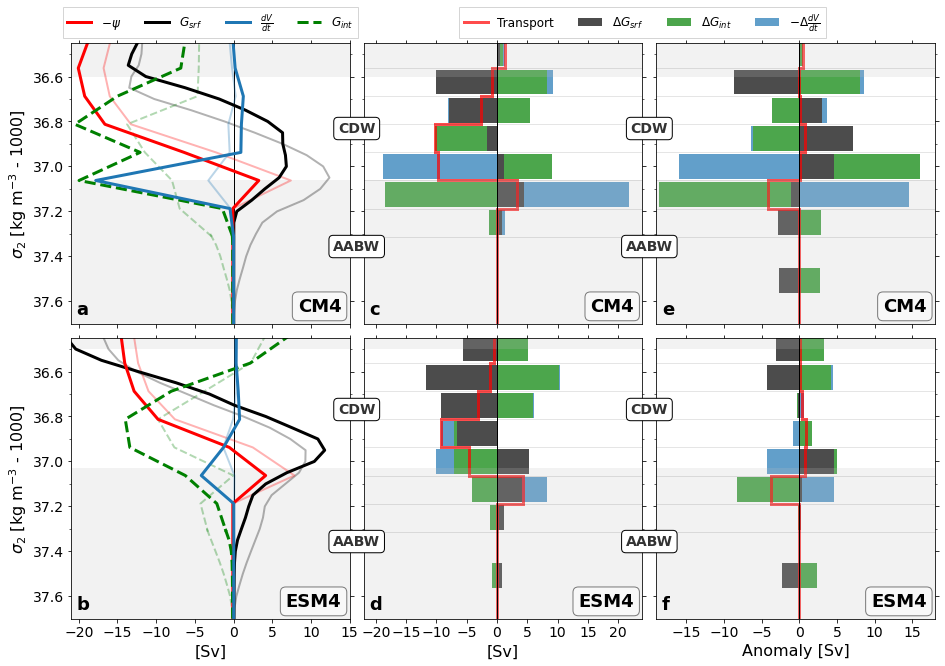

In [9]:
exp='antwater'

fig, axs = plt.subplots(2, 3, figsize=(15,10))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace = 0.05, wspace = 0.05)

for i, mod in enumerate(ddict):
    
    ti = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
    tf = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
    
    ################### Calc WMT (control) ###################
    psi_ctrl = tsdict[mod]['control']['psi'].sel(time=slice(ti,tf)).mean('time')
    dVdt_ctrl = tsdict[mod]['control']['dVdt'].sel(time=slice(ti,tf)).mean('time')
    G_ctrl = ddict[mod]['control']['swmt'].sel(time=slice(ti,tf)).mean('time')*1e-6
    G_ctrl_interp = tsdict[mod]['control']['swmt'].sel(time=slice(ti,tf)).mean('time')
    G_ctrl_int = dVdt_ctrl + psi_ctrl - G_ctrl_interp
    
    psi_ctrl_interp = psi_ctrl.interp(sigma2=G_ctrl.sigma2,kwargs={'fill_value':0})
    dVdt_ctrl_interp = dVdt_ctrl.interp(sigma2=G_ctrl.sigma2,kwargs={'fill_value':0})
    G_ctrl_int_interp = dVdt_ctrl_interp+psi_ctrl_interp-G_ctrl
    
    ################### Calc WMF (control) ###################
    
    # Surface Formation/Destruction
    dG_ctrl = -1.*G_ctrl_interp.diff('sigma2',label='lower')
    dG_ctrl['sigma2'] = rho2_l-1000
    
    # Deflation/Inflation
    dM_ctrl = -1.*dVdt_ctrl.diff('sigma2',label='lower')
    dM_ctrl['sigma2'] = rho2_l-1000
    
    # Interior Fromation/Destruction
    dD_ctrl = -1.*G_ctrl_int.diff('sigma2',label='lower')
    dD_ctrl['sigma2'] = rho2_l-1000
    
    # Export/Import at 30S
    #dpsi_ctrl = -1.*(M_ctrl+psi_ctrl).diff('sigma2',label='lower')
    dpsi_ctrl = -1.*psi_ctrl.diff('sigma2',label='lower')
    dpsi_ctrl['sigma2'] = rho2_l-1000
    
    ################### Plot WMT (control) ###################
    
    axs[i,0].axvline(x=0, ymin=0, ymax=1, linewidth=1.0, color = 'k')
    l1,=axs[i,0].plot(G_ctrl, G_ctrl.sigma2, color='k', linestyle='-',lw=2, alpha=0.3, label = '$G_{srf}$')
    l2,=axs[i,0].plot(psi_ctrl,psi_ctrl.sigma2, color='r', linestyle='-',lw=2, alpha=0.3, label = '$-\psi$')
    axs[i,0].plot(G_ctrl_int.sel(sigma2=slice(None,37.4)), G_ctrl_int.sigma2.sel(sigma2=slice(None,37.4)), 
                color='g', linestyle='--', lw=2, alpha=0.3)
    l3,=axs[i,0].plot(G_ctrl_int_interp.sel(sigma2=slice(37.25,None)), 
                    G_ctrl_int_interp.sigma2.sel(sigma2=slice(37.25,None)), 
                    color='g', linestyle='--', lw=2, alpha=0.3, label = '$G_{int}$')
    l4,=axs[i,0].plot(dVdt_ctrl, dVdt_ctrl.sigma2, lw=2, alpha=0.3, label = '$\\frac{dV}{dt}$')
    
    ################### Calc WMT (experiment) ###################
    psi = tsdict[mod][exp]['psi'].sel(time=slice(texp[0],texp[1])).mean('time')
    dVdt = tsdict[mod][exp]['dVdt'].sel(time=slice(texp[0],texp[1])).mean('time')
    G_interp = tsdict[mod][exp]['swmt'].sel(time=slice(texp[0],texp[1])).mean('time')
    Gint = dVdt+psi-G_interp
    
    Gs=[]
    for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
        Gmem = ddict[mod][exp][mem]['swmt']*1e-6                
        if mem == '101':
            Gmem['time'] = Gmem.time - timedelta(days=365*(int(mem)-1))
            
        Gmem = Gmem.reset_coords(drop=True)
        Gmem['mem'] = int(mem)
        Gs.append(Gmem)
        
    G = xr.concat(Gs, dim='mem').sel(time=slice(texp[0],texp[1])).mean('time')
    
    psi_interp = psi.interp(sigma2=G.sigma2,kwargs={'fill_value':0})
    dVdt_interp = dVdt.interp(sigma2=G.sigma2,kwargs={'fill_value':0})
    Gint_interp = dVdt_interp+psi_interp-G
    
    ################### Calc WMF (experiment) ###################
    
    # Surface Formation/Destruction
    dG = -1.*G_interp.diff('sigma2',label='lower')
    dG['sigma2'] = rho2_l-1000
    
    # Deflation/Inflation    
    dM = -1.*dVdt.diff('sigma2',label='lower')
    dM['sigma2'] = rho2_l-1000
    
    # Interior Fromation/Destruction
    dD = -1.*Gint.diff('sigma2',label='lower')
    dD['sigma2'] = rho2_l-1000
    
    # Export/Import at 30S
    #dpsi = -1.*(M+psi).diff('sigma2',label='lower')
    dpsi = -1.*psi.diff('sigma2',label='lower')
    dpsi['sigma2'] = rho2_l-1000
    
    ds = dpsi.mean('mem').reset_coords(drop=True).to_dataset(name='psi')
    ds['wmt'] = dG.mean('mem').reset_coords(drop=True)
    ds['lvc'] = -1.*dM.mean('mem').reset_coords(drop=True)
    ds['mix'] = dD.mean('mem').reset_coords(drop=True)
    df = ds.to_dataframe()
    df.rename(index={df.index[-1]:37.3125+(37.7-37.3125)/2}, inplace=True)
    
    
    ### Calculate the difference between control and pertubation
    dpsi_diff = dpsi.mean('mem') - dpsi_ctrl
    dG_diff = dG.mean('mem') - dG_ctrl
    dM_diff = ds['lvc'] - (-1.*dM_ctrl)
    dD_diff = dD.mean('mem') - dD_ctrl
    
    ds_diff = dpsi_diff.reset_coords(drop=True).to_dataset(name='psi')
    ds_diff['wmt'] = dG_diff.reset_coords(drop=True)
    ds_diff['lvc'] = dM_diff.reset_coords(drop=True)
    ds_diff['mix'] = dD_diff.reset_coords(drop=True)
    df_diff = ds_diff.to_dataframe()
    df_diff.rename(index={df_diff.index[-1]:37.3125+(37.7-37.3125)/2}, inplace=True)
    
    ################### Plot WMT (experiment) ###################
    
    l1,=axs[i,0].plot(G.mean('mem'), G.sigma2, color='k', linestyle='-',lw=3, label = '$G_{srf}$')
    #axs[i,0].fill_betweenx(G.sigma2, G.mean('mem')-G.std('mem'), G.mean('mem')+G.std('mem'), 
    #                     alpha=0.1, edgecolor='k', facecolor='k')
    l2,=axs[i,0].plot(psi.mean('mem'),psi.sigma2, color='r', linestyle='-',lw=3, label = '$-\psi$')
    
    axs[i,0].plot(Gint.mean('mem').sel(sigma2=slice(None,37.4)), Gint.sigma2.sel(sigma2=slice(None,37.4)), 
                color='g', linestyle='--', lw=3, label = '$G_{int}$')
    l3,=axs[i,0].plot(Gint_interp.mean('mem').sel(sigma2=slice(37.25,None)), 
                    Gint_interp.sigma2.sel(sigma2=slice(37.25,None)), 
                    color='g', linestyle='--', lw=3, label = '$G_{int}$')
    
    #l3,=axs[i,0].plot(Gint.mean('mem'), Gint.sigma2, color='g', linestyle='--', lw=3, label = '$G_{int}$')
    l4,=axs[i,0].plot(dVdt.mean('mem'),dVdt.sigma2,lw=3,c='tab:blue', label = '$\\frac{dV}{dt}$')
    #axs[i,0].fill_betweenx(dVdt.sigma2, dVdt.mean('mem')-dVdt.std('mem'), dVdt.mean('mem')+dVdt.std('mem'), 
    #                       alpha=0.3, edgecolor='tab:blue', facecolor='tab:blue')
    axs[i,0].set_xlim([-21,15])
    axs[i,0].set_xticks(np.arange(-20,20,5))
    
    ################### Plot WMF (experiment) ###################
    
    #divider = make_axes_locatable(axs[i,1])
    #ax1 = divider.new_horizontal(size='15%', pad=0.05, pack_start=True)
    #fig.add_axes(ax1)
    #ax1.spines['right'].set_visible(False)
    
    #ax2 = divider.new_horizontal(size='15%', pad=0.05)
    #fig.add_axes(ax2)
    #ax2.spines['left'].set_visible(False)
    #ax2.tick_params(axis='y',which='both',bottom=False,labelbottom=False)
    
    #axs[i,1].spines['right'].set_visible(False)
    #axs[i,1].spines['left'].set_visible(False)
    #axs[i,1].tick_params(axis='y',which='both',bottom=False,labelbottom=False)
    
    #d = .25
    #kwargs = dict(marker=[(-d, -1), (d, 1)], markersize=12,
    #              linestyle='none', color='k', mec='k', mew=1, clip_on=False)
    #ax2.plot([0, 0],[0, 1], transform=ax2.transAxes, **kwargs)
    #axs[i,1].plot([0, 1], [1, 1], transform=axs[i,1].transAxes, **kwargs)
    #axs[i,1].plot([0, 1], [0, 0], transform=axs[i,1].transAxes, **kwargs)
    #ax1.plot([0, 1], [1, 1], transform=ax1.transAxes, **kwargs)
    
    axs[i,1].axvline(x=0, ymin=0, ymax=1, linewidth=1.0, color = 'k')
    for val in rho2_i:
        axs[i,1].axhline(y=val-1000, c='k', lw=1, alpha=0.1)
        
    for term in [df[df>0].fillna(0),df[df<0].fillna(0)]:
        p1 = axs[i,1].barh(term.index, term.wmt, bar_width, align='center', alpha=0.7, color='k', left=0)
        p2 = axs[i,1].barh(term.index, term.mix, bar_width, align='center', alpha=0.7, color='g', left=term.wmt)
        p3 = axs[i,1].barh(term.index, term.lvc, bar_width, align='center', alpha=0.7, color='tab:blue',
                          left=term.wmt+term.mix)
    p4 = axs[i,1].stairs(df.psi.values, edges=rho2_i-1000, color='r', lw=3, ls='-',alpha=0.7,
                         orientation='horizontal',label='Transport')#,label='Export (+) / Import (-)')
    
    #p1.set_label('Srf. formation (+) / destuction (-)')
    p1.set_label('$\Delta G_{srf}$')
    p2.set_label('$\Delta G_{int}$')
    p3.set_label('$-\Delta\\frac{dV}{dt}$')
    
    axs[i,1].set_xlim([-22, 24])
    axs[i,1].set_xticks(np.arange(-20,25,5))
    
    ################### Plot WMF (experiment) difference ###################
    
    axs[i,2].axvline(x=0, ymin=0, ymax=1, linewidth=1.0, color = 'k')
    for val in rho2_i:
        axs[i,2].axhline(y=val-1000, c='k', lw=1, alpha=0.1)
        
    for term in [df_diff[df_diff>0].fillna(0),df_diff[df_diff<0].fillna(0)]:
        p1 = axs[i,2].barh(term.index, term.wmt, bar_width, align='center', alpha=0.7, color='k', left=0)
        p2 = axs[i,2].barh(term.index, term.mix, bar_width, align='center', alpha=0.7, color='g', left=term.wmt)
        p3 = axs[i,2].barh(term.index, term.lvc, bar_width, align='center', alpha=0.7, color='tab:blue',
                           left=term.wmt+term.mix)
    p4 = axs[i,2].stairs(df_diff.psi.values, edges=rho2_i-1000, color='r', lw=3, ls='-',alpha=0.7,
                         orientation='horizontal',label='Transport')#,label='Export (+) / Import (-)')
    
    axs[i,2].set_xlim([-19, 18])
    axs[i,2].set_xticks(np.arange(-15,20,5))

    for j in [0,1,2]:
        
        axs[i,j].set_ylim([36.45,37.7])
        axs[i,j].set_yticks(np.arange(36.5,37.5,0.1), minor=True)
        axs[i,j].text(0.02, 0.02, lttr[i][j], ha='left', va='bottom', fontsize=18, fontweight='bold', 
                      transform=axs[i,j].transAxes)
        axs[i,j].text(0.97, 0.03, mod, ha='right', va='bottom', fontsize=18, fontweight='bold', 
                      transform=axs[i,j].transAxes, bbox = dict(boxstyle='round', facecolor='w', alpha=0.5))
    
        xlimit = axs[i,j].get_xlim()
        ylimit = axs[i,j].get_ylim()
        
        widx=2
        xy = (xlimit[0],ylimit[0])
        rwidth = ddict_wm[mod]['sig2'][widx]-ylimit[0]
        rect = axs[i,j].add_patch(plt.Rectangle(xy, abs(xlimit[1]-xlimit[0]), rwidth,facecolor='silver',
                                                clip_on=False,linewidth = 0,alpha=0.2))
        
        widx=4
        xy = xlimit[0], ddict_wm[mod]['sig2'][widx-1]
        rwidth = ylimit[1]-ddict_wm[mod]['sig2'][widx-1]
        rect = axs[i,j].add_patch(plt.Rectangle(xy, abs(xlimit[1]-xlimit[0]), rwidth,facecolor='silver',
                                                clip_on=False,linewidth = 0,alpha=0.2))
        
        axs[i,j].tick_params(axis='both', which='both', labelsize=14, top=True, right=True)
        axs[i,j].invert_yaxis()
        
        if j == 0:
            axs[i,j].set_ylabel(r'$\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=16)
        else:
            #axs[i,j].xaxis.label.set_visible(False)
            axs[i,j].set_yticklabels([])
        
        if i == 1:
            if j<2:
                axs[i,j].set_xlabel(r'[Sv]',fontsize=16)
            else:
                axs[i,j].set_xlabel(r'Anomaly [Sv]',fontsize=16)
        else:
            axs[i,j].set_xticklabels([])
            #print('Wait')
            
            
    for j in [0,1]:
        axs[i,j].text(1.025, 0.67 if mod =='CM4' else 0.72, 'CDW', fontsize=14, fontweight='bold',
                      ha='center', va='bottom',color='k',alpha=0.8,#rotation=270,
                      bbox=dict(boxstyle="round",ec='k',fc='w'), transform=axs[i,j].transAxes)
        fig.texts.append(axs[i,j].texts.pop())
        axs[i,j].text(1.025, 0.25, 'AABW', fontsize=14, fontweight='bold',
                      ha='center', va='bottom',color='k',alpha=0.8,#rotation=270,
                      bbox=dict(boxstyle="round",ec='k',fc='w'), transform=axs[i,j].transAxes)
        fig.texts.append(axs[i,j].texts.pop())

leg1 = axs[0,0].legend(handles=[l2,l1,l4,l3], frameon=True, fancybox=False, bbox_to_anchor=(0.5, 1.15), 
                     loc='upper center', ncol=4, fontsize=12)
leg2 = axs[0,1].legend(frameon=True, fancybox=False, bbox_to_anchor=(1.0, 1.15), loc='upper center', 
                       ncol=4, fontsize=12)

plt.savefig('volbal_faf.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)

plt.show()

**Figure 7**: (a,b) Same as Figure 6 a and b, but including the mean of the last 20 years of the Antwater experiment (year 51-70) as highlighted curves. The curves for the 100-year mean of the control runs (as presented in Figure 6) are shown in lighter hue for reference.(c,d) Same as Figure 6 c and d, but for the last 20 years of the Antwater experiment (year 51-70). (e,f) Anomalies in the export/import at 30$^\circ$S (red line), formation/destruction from surface (black bars) and interior WMT (green bars) and storage change (blue bars). Anomalies are calculated from the mean of the last 20 years (year 51-70) in Antwater minus the 100-year mean of the corresponding Control.

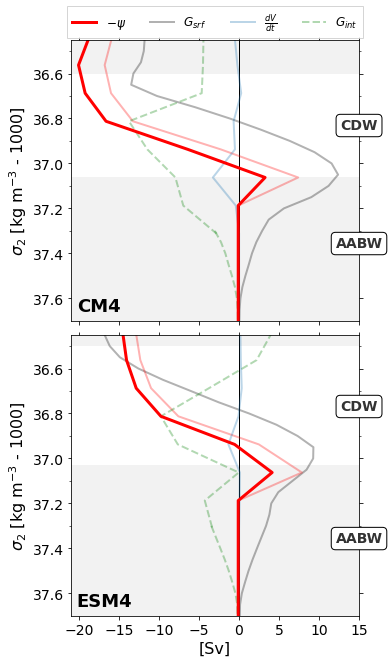

In [34]:
exp='antwater'

fig, axs = plt.subplots(2, 1, figsize=(5,10))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9,hspace = 0.05)

for i, mod in enumerate(ddict):
    
    ti = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
    tf = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
    psi_ctrl = tsdict[mod]['control']['psi'].sel(time=slice(ti,tf)).mean('time')
    dVdt_ctrl = tsdict[mod]['control']['dVdt'].sel(time=slice(ti,tf)).mean('time')
    G_ctrl = ddict[mod]['control']['swmt'].sel(time=slice(ti,tf)).mean('time')*1e-6
    G_ctrl_interp = tsdict[mod]['control']['swmt'].sel(time=slice(ti,tf)).mean('time')
    G_ctrl_int = dVdt_ctrl + psi_ctrl - G_ctrl_interp
    
    psi_ctrl_interp = psi_ctrl.interp(sigma2=G_ctrl.sigma2,kwargs={'fill_value':0})
    dVdt_ctrl_interp = dVdt_ctrl.interp(sigma2=G_ctrl.sigma2,kwargs={'fill_value':0})
    G_ctrl_int_interp = dVdt_ctrl_interp+psi_ctrl_interp-G_ctrl
    
    
    axs[i].axvline(x=0, ymin=0, ymax=1, linewidth=1.0, color = 'k')
    l1,=axs[i].plot(G_ctrl, G_ctrl.sigma2, color='k', linestyle='-',lw=2, alpha=0.3, label = '$G_{srf}$')
    l2,=axs[i].plot(psi_ctrl,psi_ctrl.sigma2, color='r', linestyle='-',lw=2, alpha=0.3, label = '$-\psi$')
    axs[i].plot(G_ctrl_int.sel(sigma2=slice(None,37.4)), G_ctrl_int.sigma2.sel(sigma2=slice(None,37.4)), 
                color='g', linestyle='--', lw=2, alpha=0.3)
    l3,=axs[i].plot(G_ctrl_int_interp.sel(sigma2=slice(37.25,None)), 
                    G_ctrl_int_interp.sigma2.sel(sigma2=slice(37.25,None)), 
                    color='g', linestyle='--', lw=2, alpha=0.3, label = '$G_{int}$')
    l4,=axs[i].plot(dVdt_ctrl, dVdt_ctrl.sigma2, lw=2, alpha=0.3, label = '$\\frac{dV}{dt}$')
    
    psi = tsdict[mod][exp]['psi'].sel(time=slice(texp[0],texp[1])).mean('time')
    dVdt = tsdict[mod][exp]['dVdt'].sel(time=slice(texp[0],texp[1])).mean('time')
    G_interp = tsdict[mod][exp]['swmt'].sel(time=slice(texp[0],texp[1])).mean('time')
    Gint = dVdt+psi-G_interp
    
    Gs=[]
    for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
        Gmem = ddict[mod][exp][mem]['swmt']*1e-6                
        if mem == '101':
            Gmem['time'] = Gmem.time - timedelta(days=365*(int(mem)-1))
            
        Gmem = Gmem.reset_coords(drop=True)
        Gmem['mem'] = int(mem)
        Gs.append(Gmem)
        
    G = xr.concat(Gs, dim='mem').sel(time=slice(texp[0],texp[1])).mean('time')
    
    psi_interp = psi.interp(sigma2=G.sigma2,kwargs={'fill_value':0})
    dVdt_interp = dVdt.interp(sigma2=G.sigma2,kwargs={'fill_value':0})
    Gint_interp = dVdt_interp+psi_interp-G
    
    #l1,=axs[i].plot(G.mean('mem'), G.sigma2, color='k', linestyle='-',lw=3, label = '$G_{srf}$')
    #axs[i].fill_betweenx(G.sigma2, G.mean('mem')-G.std('mem'), G.mean('mem')+G.std('mem'), 
    #                     alpha=0.1, edgecolor='k', facecolor='k')
    l2,=axs[i].plot(psi.mean('mem'),psi.sigma2, color='r', linestyle='-',lw=3, label = '$-\psi$')
    
    #axs[i].plot(Gint.mean('mem').sel(sigma2=slice(None,37.4)), Gint.sigma2.sel(sigma2=slice(None,37.4)), 
    #            color='g', linestyle='--', lw=3, label = '$G_{int}$')
    #l3,=axs[i].plot(Gint_interp.mean('mem').sel(sigma2=slice(37.25,None)), 
    #                Gint_interp.sigma2.sel(sigma2=slice(37.25,None)), 
    #                color='g', linestyle='--', lw=3, label = '$G_{int}$')
    
    
    #l3,=axs[i].plot(Gint.mean('mem'), Gint.sigma2, color='g', linestyle='--', lw=3, label = '$G_{int}$')
    #l4,=axs[i].plot(dVdt.mean('mem'),dVdt.sigma2,lw=3,c='tab:blue', label = '$\\frac{dV}{dt}$')
    #axs[i].fill_betweenx(dVdt.sigma2, dVdt.mean('mem')-dVdt.std('mem'), dVdt.mean('mem')+dVdt.std('mem'), 
    #                     alpha=0.3, edgecolor='tab:blue', facecolor='tab:blue')
    
    axs[i].set_ylim([36.45,37.7])
    axs[i].set_yticks(np.arange(36.5,37.5,0.1), minor=True)
    axs[i].set_xlim([-21,15])
    axs[i].set_xticks(np.arange(-20,20,5))
    axs[i].text(0.02, 0.02, mod, ha='left', va='bottom', fontsize=18, fontweight='bold', transform=axs[i].transAxes)
    
    xlimit = axs[i].get_xlim()
    ylimit = axs[i].get_ylim()
    
    widx=2
    xy = (xlimit[0],ylimit[0])
    rwidth = ddict_wm[mod]['sig2'][widx]-ylimit[0]
    rect = axs[i].add_patch(plt.Rectangle(xy, abs(xlimit[1]-xlimit[0]), rwidth,facecolor='silver',
                                          clip_on=False,linewidth = 0,alpha=0.2)) 
        
    widx=4
    xy = xlimit[0], ddict_wm[mod]['sig2'][widx-1]
    rwidth = ylimit[1]-ddict_wm[mod]['sig2'][widx-1]
    rect = axs[i].add_patch(plt.Rectangle(xy, abs(xlimit[1]-xlimit[0]), rwidth,facecolor='silver',
                                          clip_on=False,linewidth = 0,alpha=0.2))
    
    axs[i].text(1, 0.67 if mod =='CM4' else 0.72, 'CDW', fontsize=14, fontweight='bold',
                ha='center', va='bottom',color='k',alpha=0.8,#rotation=270,
                bbox=dict(boxstyle="round",ec='k',fc='w'), transform=axs[i].transAxes)
    axs[i].text(1, 0.25, 'AABW', fontsize=14, fontweight='bold',
                ha='center', va='bottom',color='k',alpha=0.8,#rotation=270,
                bbox=dict(boxstyle="round",ec='k',fc='w'), transform=axs[i].transAxes)        

    axs[i].tick_params(axis='both', which='both', labelsize=14,top=True,right=True)
    
    axs[i].invert_yaxis()
    axs[i].set_ylabel(r'$\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=16)
    
    #sig_max = 37.05 if mod=='CM4' else 36.95
    #sig_max = 36.95
    #axs[i].axhline(y=sig_max, xmin=0, xmax=1, linewidth=1.5, color = 'k',alpha=0.7,ls='--')
    #axs[i].text(-18.5,sig_max+0.01, r'$\sigma_2$ =%.2f kg m$^{-3}$'%sig_max, c='k',
    #        horizontalalignment='left',verticalalignment='top',fontsize=12)
    
axs[0].set_xticklabels([])
axs[1].set_xlabel(r'[Sv]',fontsize=16)

leg1 = axs[0].legend(handles=[l2,l1,l4,l3], frameon=True, fancybox=False, bbox_to_anchor=(0.5, 1.14), 
                     loc='upper center', ncol=4, fontsize=12)

plt.show()

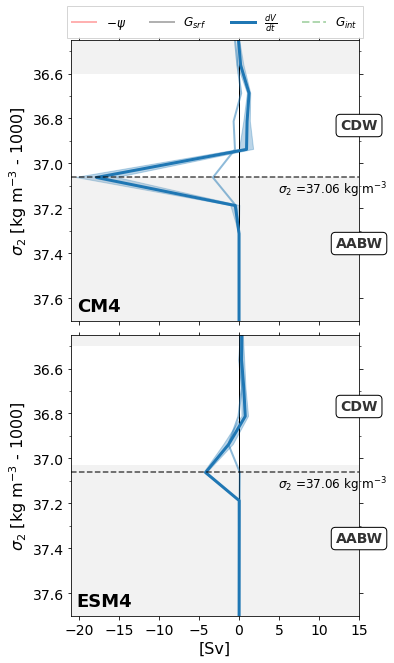

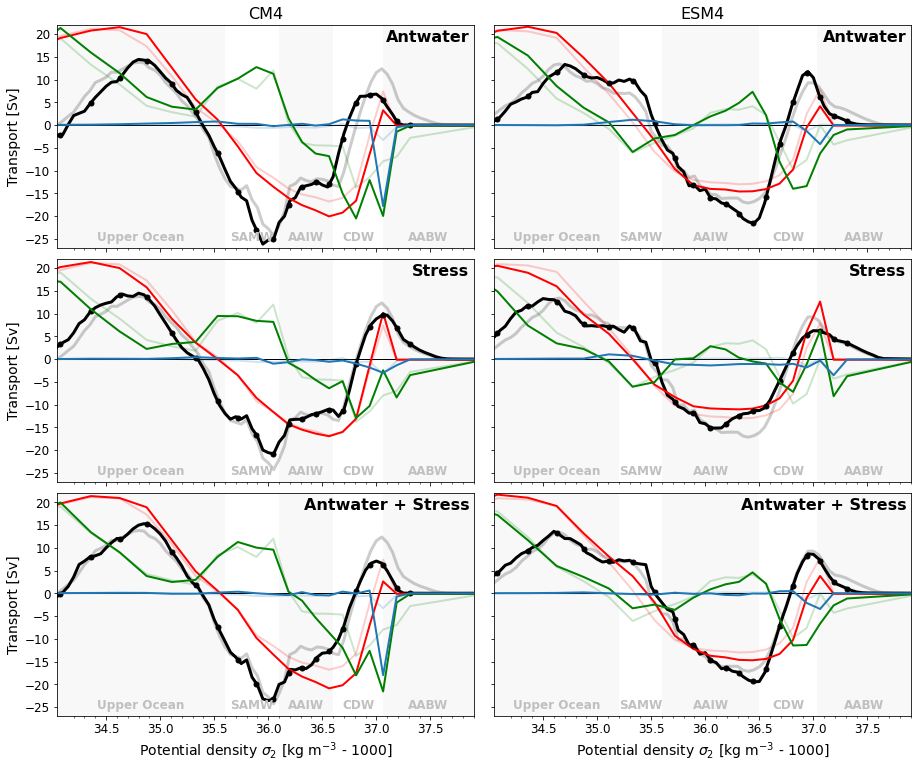

In [7]:
fig, axs = plt.subplots(3, 2, sharex=False, sharey=False, figsize=(15,12))
fig.subplots_adjust(left=0.1, right=0.89, bottom=0.1, top=0.9, hspace=0.05, wspace=0.05)

for i, mod in enumerate(ddict):
    
    ti = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
    tf = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
    psi_ctrl = tsdict[mod]['control']['psi'].sel(time=slice(ti,tf)).mean('time')
    dVdt_ctrl = tsdict[mod]['control']['dVdt'].sel(time=slice(ti,tf)).mean('time')
    G_ctrl = ddict[mod]['control']['swmt'].sel(time=slice(ti,tf)).mean('time')*1e-6
    G_ctrl_interp = tsdict[mod]['control']['swmt'].sel(time=slice(ti,tf)).mean('time')
            
    for j, exp in enumerate(list(ddict[mod].keys())[1:]):
        ti = texp[0]
        tf = texp[1]
        
        psi = tsdict[mod][exp]['psi'].sel(time=slice(ti,tf)).mean('time')
        dVdt = tsdict[mod][exp]['dVdt'].sel(time=slice(ti,tf)).mean('time')
        G_interp = tsdict[mod][exp]['swmt'].sel(time=slice(ti,tf)).mean('time')
        
        Gs=[]
        for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
            Gmem = ddict[mod][exp][mem]['swmt']*1e-6                
            if mem == '101':
                Gmem['time'] = Gmem.time - timedelta(days=365*(int(mem)-1))
            
            Gmem = Gmem.reset_coords(drop=True)
            Gmem['mem'] = int(mem)
            Gs.append(Gmem)
        
        G = xr.concat(Gs, dim='mem').sel(time=slice(ti,tf)).mean('time')
            
        
        axs[j,i].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
        axs[j,i].plot(G_ctrl.sigma2, G_ctrl, c='k', ls='-',lw=3, alpha=0.2)
        axs[j,i].plot(psi_ctrl.sigma2, psi_ctrl, c='r', ls='-',lw=2, alpha=0.2)
        (dVdt_ctrl + psi_ctrl - G_ctrl_interp)\
            .plot(ax=axs[j,i], c='g', ls='-', lw=2, alpha=0.2,_labels=None)
        dVdt_ctrl.plot(ax=axs[j,i], c='tab:blue', ls='-', lw=2, alpha=0.2,_labels=None)
        
        le1,=axs[j,i].plot(G.sigma2, G.mean('mem'), color='k', linestyle='-',lw=3, 
                           label = '$G_{srf}$ (experiment)')
        le2,=axs[j,i].plot(psi.sigma2, psi.mean('mem'), color='r', linestyle='-',lw=2, label = '$\psi$')
        axs[j,i].plot(G_interp.sigma2, G_interp.mean('mem'), marker='o',ms=5, c='k', ls='none')
        le3,=(dVdt + psi - G_interp).mean('mem')\
            .plot(ax=axs[j,i], color='g', linestyle='-', lw=2, 
                  label = '$G_{int}$',_labels=None)
        le4,=axs[j,i].plot(dVdt.sigma2, dVdt.mean('mem'), lw=2,c='tab:blue', label = '$\\frac{dV}{dt}$')
        
        
        axs[j,i].set_xlim([34.05,37.8])
        axs[j,i].set_xticks(np.arange(34.2,38,0.1), minor=True)
        axs[j,i].set_ylim([-27,22])
        axs[j,i].set_yticks(np.arange(-25,25,5))
        axs[j,i].tick_params(axis='both', which='major', labelsize=12)
        
        axs[j,i].text(0.99, 0.98, exp[:8].capitalize()+' + '+exp[8:].capitalize() \
                      if exp=='antwaterstress' else exp.capitalize(), 
                      ha='right', va='top', fontsize=16, fontweight='bold',
                      transform=axs[j,i].transAxes)
        
        if exp != 'antwaterstress':
            axs[j,i].set_xticklabels([])
        else:
            axs[j,i].set_xlabel(r'Potential density $\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)
            
        if mod == 'CM4':
            axs[j,i].set_ylabel(r'Transport [Sv]',fontsize=14)
        else:
            axs[j,i].set_yticklabels([])
            
        xlimit = axs[j,i].get_xlim()
        ylimit = axs[j,i].get_ylim()
        for widx, wm in enumerate(ddict_wm[mod]['water_mass']):
            xy = (xlimit[0],ylimit[0]) if widx==0 else (ddict_wm[mod]['sig2'][widx-1],ylimit[0])
            rwidth = ddict_wm[mod]['sig2'][widx]-xlimit[0] if widx==0 \
                        else ddict_wm[mod]['sig2'][widx]-ddict_wm[mod]['sig2'][widx-1] \
                        if (widx>0) & (widx<len(ddict_wm[mod]['water_mass'])-1) \
                        else xlimit[1]-ddict_wm[mod]['sig2'][widx-1]
            
            rect = axs[j,i].add_patch(plt.Rectangle(xy,rwidth, abs(ylimit[1]-ylimit[0]),facecolor='silver',
                                                  clip_on=False,linewidth = 0,alpha=0.1 if widx%2==0 else 0.0))
            axs[j,i].text(xy[0]+rwidth/2, xy[1]+1, ddict_wm[mod]['water_mass'][widx], fontsize=12, fontweight='bold',
                        ha='center', va='bottom',color='silver')
            
axs[0,0].set_title('CM4',fontsize=16)
axs[0,1].set_title('ESM4',fontsize=16)

plt.show()

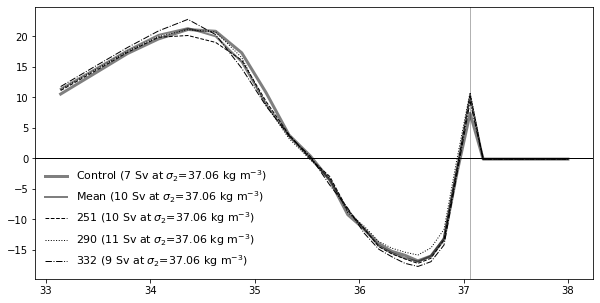

In [51]:
mod, exp = 'CM4','stress'
var = 'psi'

fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')

ti = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
tf = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
y_ctrl = tsdict[mod]['control'][var].sel(time=slice(ti,tf)).mean('time')
y = -y_ctrl.sel(sigma2=slice(36.5,None)) if var=='psi' else y_ctrl.sel(sigma2=slice(36.5,None))
x_min = np.round(y[y.argmin()][lstr].values,2)
y_min = -np.round(y[y.argmin()].values,0) if var=='psi' else np.round(y[y.argmin()].values,0)
lab =r'%.0f Sv at $\sigma_%s$=%.2f kg m$^{-3}$'%(y_min,lstr[-1],x_min)
ax.plot(y_ctrl[lstr], y_ctrl, color='k',lw=3,alpha=0.5,label='Control'+' ('+lab+')')

yy = tsdict[mod][exp][var].sel(time=slice('0051','0070')).mean('time').mean('mem')
y = -yy.sel(sigma2=slice(36.5,None)) if var=='psi' else yy.sel(sigma2=slice(36.5,None))
x_min = np.round(y[y.argmin()][lstr].values,2)
y_min = -np.round(y[y.argmin()].values,0) if var=='psi' else np.round(y[y.argmin()].values,0)
lab =r'%.0f Sv at $\sigma_%s$=%.2f kg m$^{-3}$'%(y_min,lstr[-1],x_min)
ax.plot(yy[lstr], yy, color='k',lw=2,alpha=0.5,label='Mean'+' ('+lab+')')
ax.axvline(x=x_min, c = 'k', ls='-', lw=1,alpha=0.3)
lsty = ['--',':','-.']
for k, mem in enumerate(ddict[mod][exp]):
    
    yy = tsdict[mod][exp][var].sel(time=slice('0051','0070')).mean('time').sel(mem=int(mem))
    y = -yy.sel(sigma2=slice(36.5,None)) if var=='psi' else yy.sel(sigma2=slice(36.5,None))
    x_min = np.round(y[y.argmin()][lstr].values,2)
    y_min = -np.round(y[y.argmin()].values,0) if var=='psi' else np.round(y[y.argmin()].values,0)
    lab =r'%.0f Sv at $\sigma_%s$=%.2f kg m$^{-3}$'%(y_min,lstr[-1],x_min)
    ax.plot(yy[lstr], yy, color='k', linestyle=lsty[k],lw=1, label=mem+' ('+lab+')')
    ax.legend(loc='lower left', ncol=1, fontsize=11,frameon=False)

In [8]:
mndict = {mod:{} for mod in list(ddict.keys())}
for mod in tsdict:
    mndict[mod] = {exp:{} for exp in list(ddict[mod].keys())}

In [9]:
for mod in ddict:
    for exp in ddict[mod]:
        #print(mod,exp)
        
        if exp=='control':
            yr_st = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
            yr_ed = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
        else:
            yr_st,yr_ed = '0051','0070'
        
        psi = tsdict[mod][exp]['psi'].sel(time=slice(yr_st,yr_ed)).mean('time')
        dVdt = tsdict[mod][exp]['dVdt'].sel(time=slice(yr_st,yr_ed)).mean('time')
        G = tsdict[mod][exp]['swmt'].sel(time=slice(yr_st,yr_ed)).mean('time')
        D = dVdt + psi - G
        
        mndict[mod][exp]['psi_mean'] = psi
        mndict[mod][exp]['swmt_mean'] = G
        mndict[mod][exp]['iwmt_mean'] = D
        mndict[mod][exp]['dVdt_mean'] = dVdt

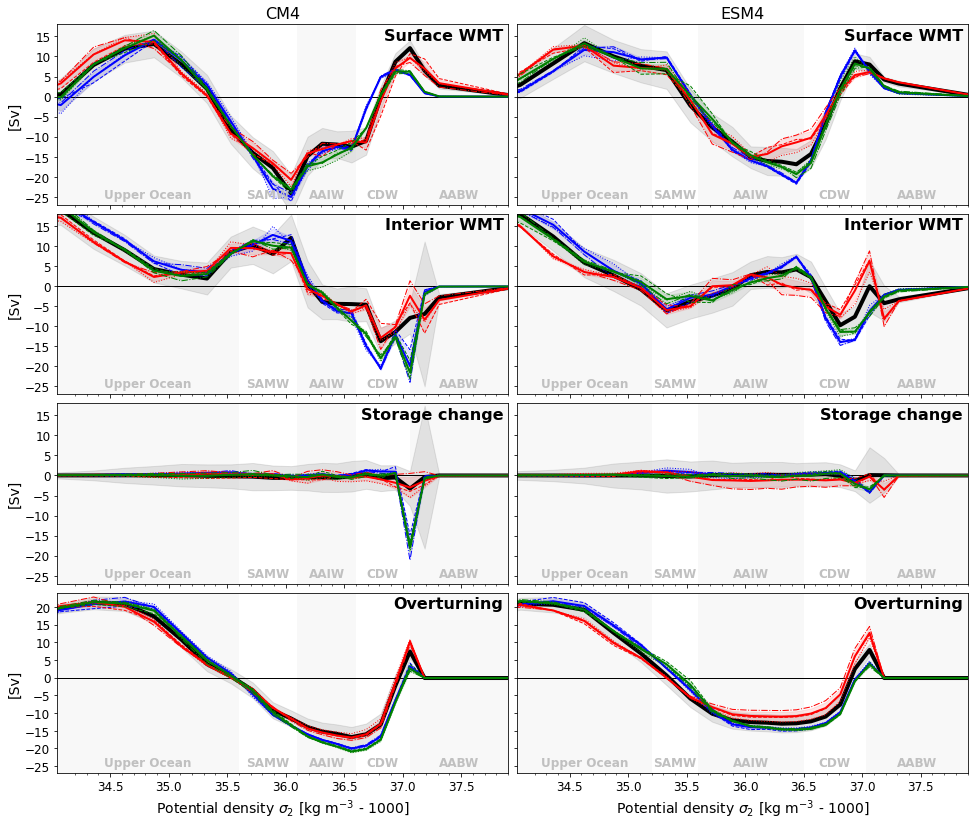

In [10]:
cstr = ['k','b','r','g']
lsty = ['--',':','-.']
tstr = ['Surface WMT','Interior WMT','Storage change','Overturning']
lstr = 'sigma2'
fig, axs = plt.subplots(4, 2, sharex=False, sharey=False, figsize=(16,13))
fig.subplots_adjust(left=0.1, right=0.89, bottom=0.1, top=0.9, hspace=0.05, wspace=0.02)

for i, mod in enumerate(ddict):
    
    for j, var in enumerate(['swmt','iwmt','dVdt','psi']):
        
        axs[j,i].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
        
        for k, exp in enumerate(ddict[mod]):
            
            if exp!='control':
                axs[j,i].fill_between(mndict[mod][exp][var+'_mean'][lstr], 
                                      mndict[mod][exp][var+'_mean'].mean('mem')\
                                      -mndict[mod][exp][var+'_mean'].std('mem'), 
                                      mndict[mod][exp][var+'_mean'].mean('mem')\
                                      +mndict[mod][exp][var+'_mean'].std('mem'), 
                                      alpha=0.1, edgecolor=cstr[k], facecolor=cstr[k])
                for m, mem in enumerate(ddict[mod][exp]):
                    axs[j,i].plot(mndict[mod][exp][var+'_mean'][lstr], 
                                  mndict[mod][exp][var+'_mean'].sel(mem=int(mem)), color=cstr[k], 
                                  linestyle=lsty[m],lw=1, label=mem)
            else:
                yr_st = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
                yr_ed = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
                if var!='iwmt':
                    da = tsdict[mod][exp][var].sel(time=slice(yr_st,yr_ed))
                else:
                    da = tsdict[mod][exp]['dVdt'].sel(time=slice(yr_st,yr_ed)) \
                    + tsdict[mod][exp]['psi'].sel(time=slice(yr_st,yr_ed)) \
                    - tsdict[mod][exp]['swmt'].sel(time=slice(yr_st,yr_ed))
                axs[j,i].fill_between(da[lstr], da.mean('time')-da.groupby('time.year').mean('time').std('year'), 
                                      da.mean('time')+da.groupby('time.year').mean('time').std('year'), 
                                      alpha=0.1, edgecolor=cstr[k], facecolor=cstr[k])
            
            axs[j,i].plot(mndict[mod][exp][var+'_mean'][lstr], 
                          mndict[mod][exp][var+'_mean'] if exp =='control' \
                          else mndict[mod][exp][var+'_mean'].mean('mem'), color=cstr[k], 
                          linestyle='-',lw=4 if exp=='control' else 2, 
                          label=exp[:8].capitalize()+' + '+exp[8:].capitalize() \
                          if exp=='antwaterstress' else exp.capitalize())
            
        axs[j,i].tick_params(axis='both', which='major', labelsize=12)
        axs[j,i].text(0.99, 0.98, tstr[j], ha='right', va='top', fontsize=16, fontweight='bold',
                      transform=axs[j,i].transAxes)
            
        axs[j,i].set_xlim([34.05,37.8])
        axs[j,i].set_xticks(np.arange(34.2,38,0.1), minor=True)
        if var=='swmt':
            axs[j,i].set_ylim([-27,18])
            axs[j,i].set_yticks(np.arange(-25,20,5))
        elif var=='iwmt':
            axs[j,i].set_ylim([-27,18])
            axs[j,i].set_yticks(np.arange(-25,20,5))
        elif var=='dVdt':
            axs[j,i].set_ylim([-27,18])
            axs[j,i].set_yticks(np.arange(-25,20,5))
        elif var=='psi':
            axs[j,i].set_ylim([-27,24])
            axs[j,i].set_yticks(np.arange(-25,25,5))
            
        if var != 'psi':
            axs[j,i].set_xticklabels([])
        else:
            axs[j,i].set_xlabel(r'Potential density $\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)
            
        if mod == 'CM4':
            axs[j,i].set_ylabel(r'[Sv]',fontsize=14)
        else:
            axs[j,i].set_yticklabels([])
            
        xlimit = axs[j,i].get_xlim()
        ylimit = axs[j,i].get_ylim()
        for widx, wm in enumerate(ddict_wm[mod]['water_mass']):
            xy = (xlimit[0],ylimit[0]) if widx==0 else (ddict_wm[mod]['sig2'][widx-1],ylimit[0])
            rwidth = ddict_wm[mod]['sig2'][widx]-xlimit[0] if widx==0 \
                        else ddict_wm[mod]['sig2'][widx]-ddict_wm[mod]['sig2'][widx-1] \
                        if (widx>0) & (widx<len(ddict_wm[mod]['water_mass'])-1) \
                        else xlimit[1]-ddict_wm[mod]['sig2'][widx-1]
            
            rect = axs[j,i].add_patch(plt.Rectangle(xy,rwidth, abs(ylimit[1]-ylimit[0]),facecolor='silver',
                                                  clip_on=False,linewidth = 0,alpha=0.1 if widx%2==0 else 0.0))
            axs[j,i].text(xy[0]+rwidth/2, xy[1]+1, ddict_wm[mod]['water_mass'][widx], fontsize=12, fontweight='bold',
                        ha='center', va='bottom',color='silver')
            
            #axs[j,i].axvline(x=37.19, ymin=0, ymax=1, linewidth=1.0, color = 'k',alpha=0.3,ls='-')
        
axs[0,0].set_title('CM4',fontsize=16)
axs[0,1].set_title('ESM4',fontsize=16)

plt.show()

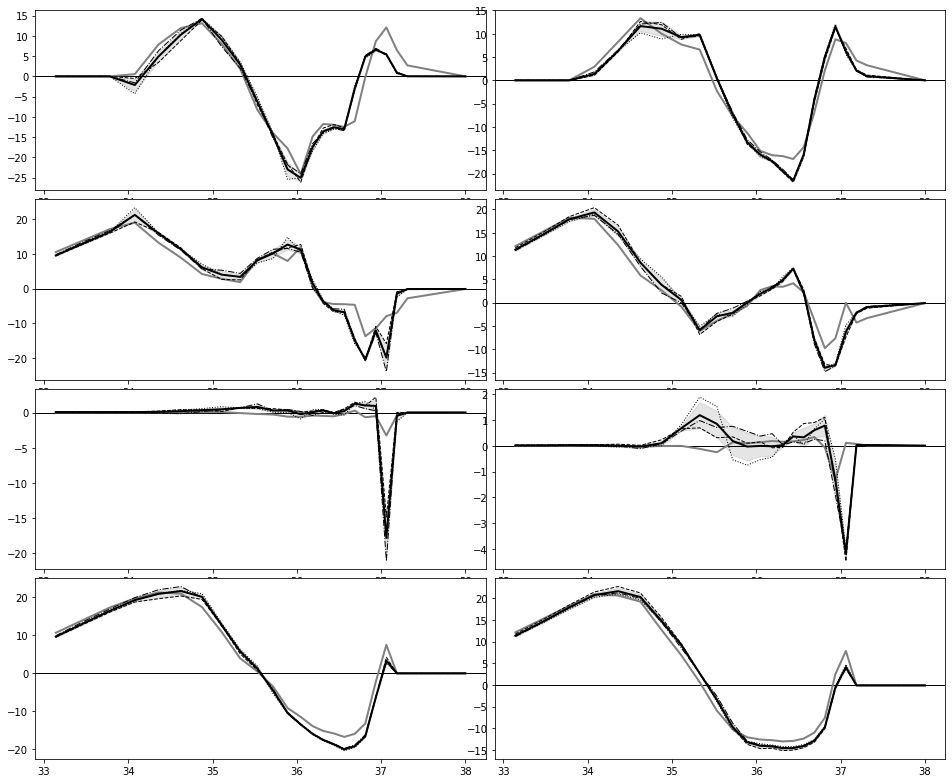

In [11]:
lsty = ['--',':','-.']
exp = 'antwater'
tstr = ['Surface WMT','Interior WMT','Storage change','Overturning']
lstr = 'sigma2'
fig, axs = plt.subplots(4, 2, sharex=False, sharey=False, figsize=(16,13))
fig.subplots_adjust(left=0.1, right=0.89, bottom=0.1, top=0.9, hspace=0.05, wspace=0.02)

for i, mod in enumerate(ddict):
    
    for j, var in enumerate(['swmt','iwmt','dVdt','psi']):
        
        axs[j,i].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
        axs[j,i].plot(mndict[mod]['control'][var+'_mean'][lstr], 
                      mndict[mod]['control'][var+'_mean'], color='grey', ls='-',lw=2, label='Control')
        axs[j,i].fill_between(mndict[mod][exp][var+'_mean'][lstr], 
                              mndict[mod][exp][var+'_mean'].mean('mem')-mndict[mod][exp][var+'_mean'].std('mem'), 
                              mndict[mod][exp][var+'_mean'].mean('mem')+mndict[mod][exp][var+'_mean'].std('mem'), 
                              alpha=0.1, edgecolor='k', facecolor='k')
        axs[j,i].plot(mndict[mod][exp][var+'_mean'][lstr], 
                      mndict[mod][exp][var+'_mean'].mean('mem'), color='k', 
                          linestyle='-',lw=2,label='Mean')
        for k, mem in enumerate(ddict[mod][exp]):
            axs[j,i].plot(mndict[mod][exp][var+'_mean'][lstr], 
                          mndict[mod][exp][var+'_mean'].sel(mem=int(mem)), color='k', 
                          linestyle=lsty[k],lw=1, label=mem)
plt.show()

In [12]:
bar_width = 0.11
add_wm=True

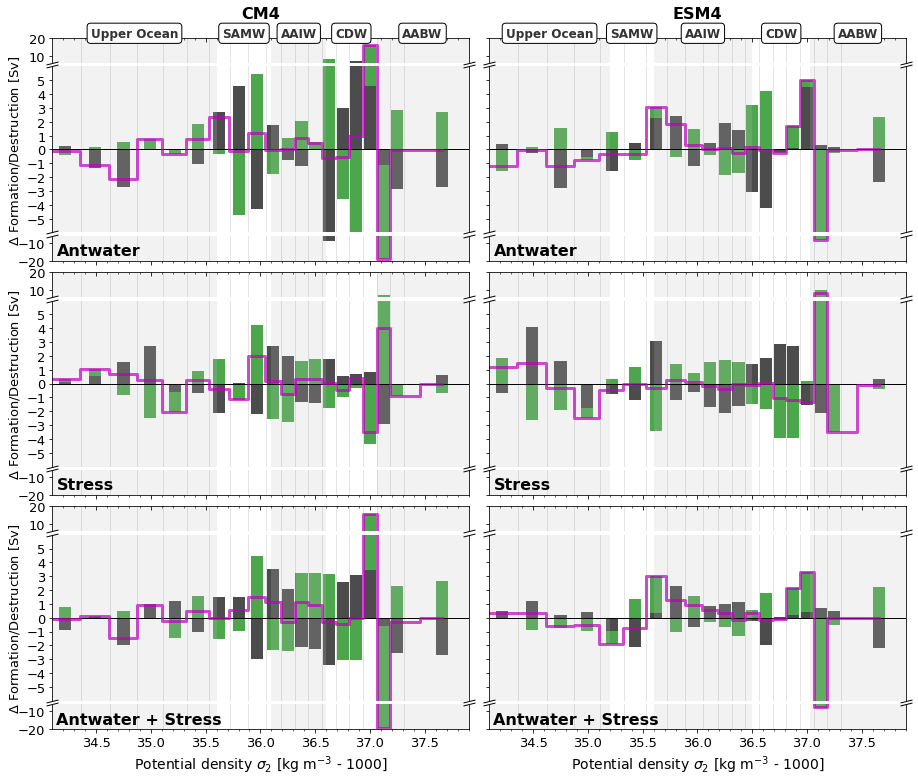

In [29]:
fig, axs = plt.subplots(3, 2, sharex=False, sharey=False, figsize=(15,12))
fig.subplots_adjust(left=0.1, right=0.89, bottom=0.1, top=0.9, hspace=0.05, wspace=0.05)

for i, mod in enumerate(ddict):
    
    ti = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
    tf = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
    psi_ctrl = tsdict[mod]['control']['psi'].sel(time=slice(ti,tf)).mean('time')
    M_ctrl = tsdict[mod]['control']['dVdt'].sel(time=slice(ti,tf)).mean('time')
    G_ctrl_interp = tsdict[mod]['control']['swmt'].sel(time=slice(ti,tf)).mean('time')
    
    dG_ctrl = -1.*G_ctrl_interp.diff('sigma2',label='lower')
    dG_ctrl['sigma2'] = rho2_l-1000
    
    dM_ctrl = -1.*M_ctrl.diff('sigma2',label='lower')
    dM_ctrl['sigma2'] = rho2_l-1000
    
    D_ctrl = M_ctrl + psi_ctrl - G_ctrl_interp
    dD_ctrl = -1.*D_ctrl.diff('sigma2',label='lower')
    dD_ctrl['sigma2'] = rho2_l-1000
    
    dpsi_ctrl = -1.*(M_ctrl+psi_ctrl).diff('sigma2',label='lower')
    dpsi_ctrl['sigma2'] = rho2_l-1000
    
    for j, exp in enumerate(list(ddict[mod].keys())[1:]):
        ti = texp[0]
        tf = texp[1]
        
        psi = tsdict[mod][exp]['psi'].sel(time=slice(ti,tf)).mean('time')
        M = tsdict[mod][exp]['dVdt'].sel(time=slice(ti,tf)).mean('time')
        G_interp = tsdict[mod][exp]['swmt'].sel(time=slice(ti,tf)).mean('time')
        
        dG = -1.*G_interp.diff('sigma2',label='lower')
        dG['sigma2'] = rho2_l-1000
        
        dM = -1.*M.diff('sigma2',label='lower')
        dM['sigma2'] = rho2_l-1000
        
        D = M + psi - G_interp
        dD = -1.*D.diff('sigma2',label='lower')
        dD['sigma2'] = rho2_l-1000
        
        dpsi = -1.*(M+psi).diff('sigma2',label='lower')
        dpsi['sigma2'] = rho2_l-1000
        
        ### Calculate the difference between control and pertubation
        
        dpsi_diff = dpsi.mean('mem') - dpsi_ctrl
        dG_diff = dG.mean('mem') - dG_ctrl
        dM_diff = dM.mean('mem') - dM_ctrl
        dD_diff = dD.mean('mem') - dD_ctrl
        
        ds = dpsi_diff.reset_coords(drop=True).to_dataset(name='psi')
        ds['wmt'] = dG_diff.reset_coords(drop=True)
        ds['lvc'] = dM_diff.reset_coords(drop=True)
        ds['mix'] = dD_diff.reset_coords(drop=True)
        df = ds.to_dataframe()
        
        divider = make_axes_locatable(axs[j,i])
        ax1 = divider.new_vertical(size='15%', pad=0.05, pack_start=True)
        fig.add_axes(ax1)
        ax1.spines['top'].set_visible(False)
        

        ax2 = divider.new_vertical(size='15%', pad=0.05)
        fig.add_axes(ax2)
        ax2.spines['bottom'].set_visible(False)
        ax2.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
        
        axs[j,i].spines['top'].set_visible(False)
        axs[j,i].spines['bottom'].set_visible(False)
        axs[j,i].tick_params(axis='x',which='both',bottom=False,labelbottom=False)

        d = .25
        kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                      linestyle='none', color='k', mec='k', mew=1, clip_on=False)
        ax2.plot([0, 1], [0, 0], transform=ax2.transAxes, **kwargs)
        axs[j,i].plot([0, 1], [1, 1], transform=axs[j,i].transAxes, **kwargs)
        axs[j,i].plot([0, 1], [0, 0], transform=axs[j,i].transAxes, **kwargs)
        ax1.plot([0, 1], [1, 1], transform=ax1.transAxes, **kwargs)

        axs[j,i].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
        
        for ax in [ax1,axs[j,i],ax2]:
            for val in rho2_i:
                ax.axvline(x=val-1000,c='k',lw=1,alpha=0.1)
                
            for term in [df[df>0].fillna(0),df[df<0].fillna(0)]:
                p1 = ax.bar(term.index, term.wmt, bar_width, align='center', alpha=0.7, color='k', bottom=0)
                p2 = ax.bar(term.index, term.mix, bar_width, align='center', alpha=0.7, color='g', bottom=term.wmt)
                
            p4 = ax.step(df.index, df.psi, where='mid', c='m', lw=3, ls='-',alpha=0.7,label='Total')
            ax.set_xlim([34.1,37.9])
            ax.set_xticks(np.arange(34.2,38,0.1), minor=True)
            ax.tick_params(axis='both', which='major', labelsize=13)
        
        ax2.xaxis.set_tick_params(top=True,direction='in')
        ax2.tick_params(axis='x', which='minor', top=True, direction='in')
        
        ax1.text(0.01, 0.10, exp[:8].capitalize()+' + '+exp[8:].capitalize() \
                 if exp=='antwaterstress' else exp.capitalize(), 
                 ha='left', va='bottom', fontsize=16, fontweight='bold',
                 transform=ax1.transAxes)
        
        if exp != 'antwaterstress':
            ax1.set_xticklabels([])
        else:
            ax1.set_xlabel(r'Potential density $\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)
        
        ax1.set_ylim(-20, -6)
        axs[j,i].set_ylim(-6, 6)
        axs[j,i].set_yticks(np.arange(-5,6,1))
        ax2.set_ylim(6, 20)
        
        if mod == 'CM4':
            axs[j,i].set_ylabel('$\Delta$ Formation/Destruction [Sv]',fontsize=13)
        else:
            axs[j,i].set_yticklabels([])
            ax1.set_yticklabels([])
            ax2.set_yticklabels([])
            
        if add_wm:
            for ax in [ax1,axs[j,i],ax2]:
                xlimit = ax.get_xlim()
                ylimit = ax.get_ylim()
                for widx, wm in enumerate(ddict_wm[mod]['water_mass']):
                    xy = (xlimit[0],ylimit[0]) if widx==0 else (ddict_wm[mod]['sig2'][widx-1],ylimit[0])
                    rwidth = ddict_wm[mod]['sig2'][widx]-xlimit[0] if widx==0 \
                            else ddict_wm[mod]['sig2'][widx]-ddict_wm[mod]['sig2'][widx-1] \
                            if (widx>0) & (widx<len(ddict_wm[mod]['water_mass'])-1) \
                            else xlimit[1]-ddict_wm[mod]['sig2'][widx-1]
                    rect = ax.add_patch(plt.Rectangle(xy,rwidth, abs(ylimit[1]-ylimit[0]),facecolor='silver',
                                                      clip_on=False,linewidth = 0,
                                                      alpha=0.2 if widx%2==0 else 0.0))
            
            if exp == 'antwater':
                xlimit = ax2.get_xlim()
                ylimit = ax2.get_ylim()
                for widx, wm in enumerate(ddict_wm[mod]['water_mass']):
                    xy = (xlimit[0],ylimit[0]) if widx==0 else (ddict_wm[mod]['sig2'][widx-1],ylimit[0])
                    rwidth = ddict_wm[mod]['sig2'][widx]-xlimit[0] if widx==0 \
                                else ddict_wm[mod]['sig2'][widx]-ddict_wm[mod]['sig2'][widx-1] \
                                if (widx>0) & (widx<len(ddict_wm[mod]['water_mass'])-1) \
                                else xlimit[1]-ddict_wm[mod]['sig2'][widx-1]
                    ax2.text(xy[0]+rwidth/2, ylimit[1]-1, ddict_wm[mod]['water_mass'][widx], fontsize=12, 
                             fontweight='bold', ha='center', va='bottom',color='k',alpha=0.8,
                             bbox=dict(boxstyle="round",ec='k',fc='w'))

axs[0,0].set_title('CM4',fontsize=16, y=1.2, pad=15,fontweight='bold')
axs[0,1].set_title('ESM4',fontsize=16, y=1.2, pad=15,fontweight='bold')

plt.show()

### Seperate figure for each experiment

In [ ]:
exp = 'antwaterstress'

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(10,8))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9,hspace = 0.05)

for i, mod in enumerate(ddict):
    
    if exp=='control':
        ti = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
        tf = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
    else:
        ti = texp[0]
        tf = texp[1]
    
    psi = tsdict[mod][exp]['psi'].sel(time=slice(ti,tf)).mean('time')
    M = tsdict[mod][exp]['dVdt'].sel(time=slice(ti,tf)).mean('time')
    G_interp = tsdict[mod][exp]['swmt'].sel(time=slice(ti,tf)).mean('time')
    
    dpsi = -1.*psi.diff('sigma2',label='lower')
    dpsi['sigma2'] = rho2_l-1000
    
    dG = -1.*G_interp.diff('sigma2',label='lower')
    dG['sigma2'] = rho2_l-1000
    
    dM = -1.*M.diff('sigma2',label='lower')
    dM['sigma2'] = rho2_l-1000
    
    D = M + psi - G_interp
    dD = -1.*D.diff('sigma2',label='lower')
    dD['sigma2'] = rho2_l-1000
    
    #dpsi = -1.*(M+psi).diff('sigma2',label='lower')
    #dpsi['sigma2'] = rho2_l-1000
    
    ds = dpsi.reset_coords(drop=True).to_dataset(name='psi') if exp=='control' \
            else dpsi.mean('mem').reset_coords(drop=True).to_dataset(name='psi')
    ds['wmt'] = dG.reset_coords(drop=True) if exp=='control' else dG.mean('mem').reset_coords(drop=True)
    ds['lvc'] = -1.*dM.reset_coords(drop=True) if exp=='control' else -1.*dM.mean('mem').reset_coords(drop=True)
    ds['mix'] = dD.reset_coords(drop=True) if exp=='control' else dD.mean('mem').reset_coords(drop=True)
    df = ds.to_dataframe()
    
    axs[i].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
    for val in rho2_i:
        axs[i].axvline(x=val-1000,c='k',lw=1,alpha=0.1)
        
    for term in [df[df>0].fillna(0),df[df<0].fillna(0)]:
        p1 = axs[i].bar(term.index, term.wmt, bar_width, align='center', alpha=0.7, color='k', bottom=0)
        p2 = axs[i].bar(term.index, term.mix, bar_width, align='center', alpha=0.7, color='g', bottom=term.wmt)
        p3 = axs[i].bar(term.index, term.lvc, bar_width, align='center', alpha=0.7, color='tab:blue',
                        bottom=term.wmt+term.mix)
        
    p4 = axs[i].step(df.index, df.psi, where='mid', c='r', lw=3, ls='-',alpha=0.7,label='Transport at 30$^{\circ}$S')
    #p4 = axs[i].step(df.index, df.psi, where='mid', c='m', lw=3, ls='-',alpha=0.7,label='Total')
    
    p1.set_label('Surface ')
    p2.set_label('Interior')
    p3.set_label('Storage change')
    
    #axs[i].set_ylim([-13, 12])
    #axs[i].set_yticks(np.arange(-12,14,2))
    axs[i].set_xlim([34.1,37.9])
    axs[i].set_xticks(np.arange(34.2,38,0.1), minor=True)
    axs[i].tick_params(axis='both', which='major', labelsize=13)
    axs[i].set_ylabel('Formation/Destruction [Sv]',fontsize=14)
    axs[i].xaxis.set_tick_params(top=True,direction='in')
    axs[i].tick_params(axis='x', which='minor', top=True,direction='in')
    
    if add_wm:
        xlimit = axs[i].get_xlim()
        ylimit = axs[i].get_ylim()
        for widx, wm in enumerate(ddict_wm[mod]['water_mass']):
            xy = (xlimit[0],ylimit[0]) if widx==0 else (ddict_wm[mod]['sig2'][widx-1],ylimit[0])
            rwidth = ddict_wm[mod]['sig2'][widx]-xlimit[0] if widx==0 \
                        else ddict_wm[mod]['sig2'][widx]-ddict_wm[mod]['sig2'][widx-1] \
                        if (widx>0) & (widx<len(ddict_wm[mod]['water_mass'])-1) \
                        else xlimit[1]-ddict_wm[mod]['sig2'][widx-1]
            rect = axs[i].add_patch(plt.Rectangle(xy,rwidth, abs(ylimit[1]-ylimit[0]),facecolor='silver',
                                                  clip_on=False, linewidth = 0,alpha=0.2 if widx%2==0 else 0.0))
            axs[i].text(xy[0]+rwidth/2, ylimit[1]-1, ddict_wm[mod]['water_mass'][widx], fontsize=12, 
                        fontweight='bold',ha='center', va='bottom',color='k',alpha=0.8,
                        bbox=dict(boxstyle="round",ec='k',fc='w'))
            
    axs[i].text(0.99, 0.03, mod, ha='right', va='bottom', fontsize=16, fontweight='bold',
                transform=axs[i].transAxes)

leg1 = axs[1].legend(fontsize=12, loc='lower left', frameon=True, fancybox=True,  ncol=2)
axs[1].set_xlabel(r'Potential density $\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)
axs[0].set_xticklabels([])
axs[0].set_title(exp.capitalize(),fontsize=16, y=1.0, pad=15,fontweight='bold')

plt.show()

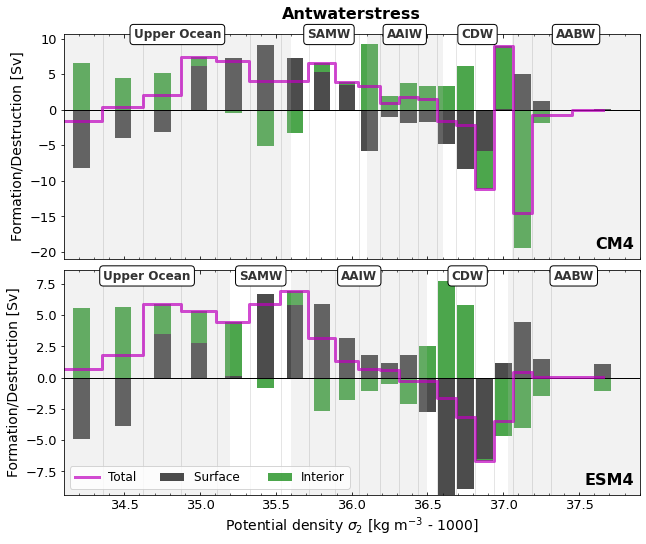

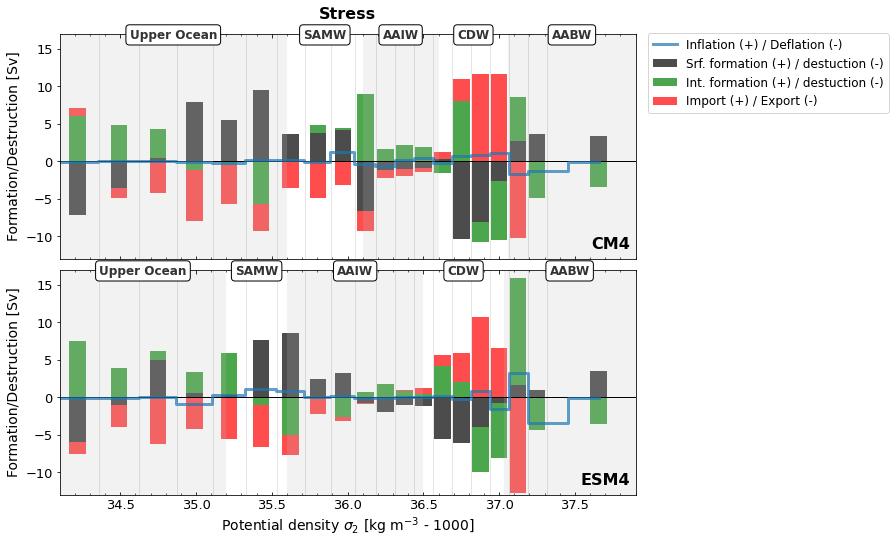

In [22]:
exp = 'stress'

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(10,8))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9,hspace = 0.05)

for i, mod in enumerate(ddict):
    
    if exp=='control':
        ti = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
        tf = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
    else:
        ti = texp[0]
        tf = texp[1]
    
    psi = tsdict[mod][exp]['psi'].sel(time=slice(ti,tf)).mean('time')
    M = tsdict[mod][exp]['dVdt'].sel(time=slice(ti,tf)).mean('time')
    G_interp = tsdict[mod][exp]['swmt'].sel(time=slice(ti,tf)).mean('time')
    
    dpsi = -1.*psi.diff('sigma2',label='lower')
    dpsi['sigma2'] = rho2_l-1000
    
    dG = -1.*G_interp.diff('sigma2',label='lower')
    dG['sigma2'] = rho2_l-1000
    
    dM = -1.*M.diff('sigma2',label='lower')
    dM['sigma2'] = rho2_l-1000
    
    D = M + psi - G_interp
    dD = -1.*D.diff('sigma2',label='lower')
    dD['sigma2'] = rho2_l-1000
    
    ds = -1.*dpsi.reset_coords(drop=True).to_dataset(name='psi') if exp=='control' \
            else -1.*dpsi.mean('mem').reset_coords(drop=True).to_dataset(name='psi')
    ds['wmt'] = dG.reset_coords(drop=True) if exp=='control' else dG.mean('mem').reset_coords(drop=True)
    ds['lvc'] = dM.reset_coords(drop=True) if exp=='control' else dM.mean('mem').reset_coords(drop=True)
    ds['mix'] = dD.reset_coords(drop=True) if exp=='control' else dD.mean('mem').reset_coords(drop=True)
    df = ds.to_dataframe()
    
    axs[i].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
    for val in rho2_i:
        axs[i].axvline(x=val-1000,c='k',lw=1,alpha=0.1)
        
    for term in [df[df>0].fillna(0),df[df<0].fillna(0)]:
        p1 = axs[i].bar(term.index, term.wmt, bar_width, align='center', alpha=0.7, color='k', bottom=0)
        p2 = axs[i].bar(term.index, term.mix, bar_width, align='center', alpha=0.7, color='g', bottom=term.wmt)
        p3 = axs[i].bar(term.index, term.psi, bar_width, align='center', alpha=0.7, color='r',
                        bottom=term.wmt+term.mix)
        
    p4 = axs[i].step(df.index, df.lvc, where='mid', c='tab:blue', lw=3, ls='-',alpha=0.7,
                     label='Inflation (+) / Deflation (-)')
    #p4 = axs[i].step(df.index, df.psi, where='mid', c='m', lw=3, ls='-',alpha=0.7,label='Total')
    
    p1.set_label('Srf. formation (+) / destuction (-)')
    p2.set_label('Int. formation (+) / destuction (-)')
    p3.set_label('Import (+) / Export (-)')
    
    #axs[i].set_ylim([-24, 21] if mod=='CM4' else [-13, 12]) # Antwater
    axs[i].set_ylim([-13, 17]) # Stress
    #axs[i].set_yticks(np.arange(-20,25,5) if mod=='CM4' else np.arange(-10,15,5))
    axs[i].set_xlim([34.1,37.9])
    axs[i].set_xticks(np.arange(34.2,38,0.1), minor=True)
    axs[i].tick_params(axis='both', which='major', labelsize=13)
    axs[i].set_ylabel('Formation/Destruction [Sv]',fontsize=14)
    axs[i].xaxis.set_tick_params(top=True,direction='in')
    axs[i].tick_params(axis='x', which='minor', top=True,direction='in')
    
    if add_wm:
        xlimit = axs[i].get_xlim()
        ylimit = axs[i].get_ylim()
        for widx, wm in enumerate(ddict_wm[mod]['water_mass']):
            xy = (xlimit[0],ylimit[0]) if widx==0 else (ddict_wm[mod]['sig2'][widx-1],ylimit[0])
            rwidth = ddict_wm[mod]['sig2'][widx]-xlimit[0] if widx==0 \
                        else ddict_wm[mod]['sig2'][widx]-ddict_wm[mod]['sig2'][widx-1] \
                        if (widx>0) & (widx<len(ddict_wm[mod]['water_mass'])-1) \
                        else xlimit[1]-ddict_wm[mod]['sig2'][widx-1]
            rect = axs[i].add_patch(plt.Rectangle(xy,rwidth, abs(ylimit[1]-ylimit[0]),facecolor='silver',
                                                  clip_on=False, linewidth = 0,alpha=0.2 if widx%2==0 else 0.0))
            axs[i].text(xy[0]+rwidth/2, ylimit[1]-1, ddict_wm[mod]['water_mass'][widx], fontsize=12, 
                        fontweight='bold',ha='center', va='bottom',color='k',alpha=0.8,
                        bbox=dict(boxstyle="round",ec='k',fc='w'))
            
    axs[i].text(0.99, 0.03, mod, ha='right', va='bottom', fontsize=16, fontweight='bold',
                transform=axs[i].transAxes)

leg1 = axs[0].legend(fontsize=12, loc='upper right', frameon=True, fancybox=True,  ncol=1,
                     bbox_to_anchor=(1.45, 1.03))
axs[1].set_xlabel(r'Potential density $\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)
axs[0].set_xticklabels([])
axs[0].set_title(exp.capitalize(),fontsize=16, y=1.0, pad=15,fontweight='bold')

plt.show()

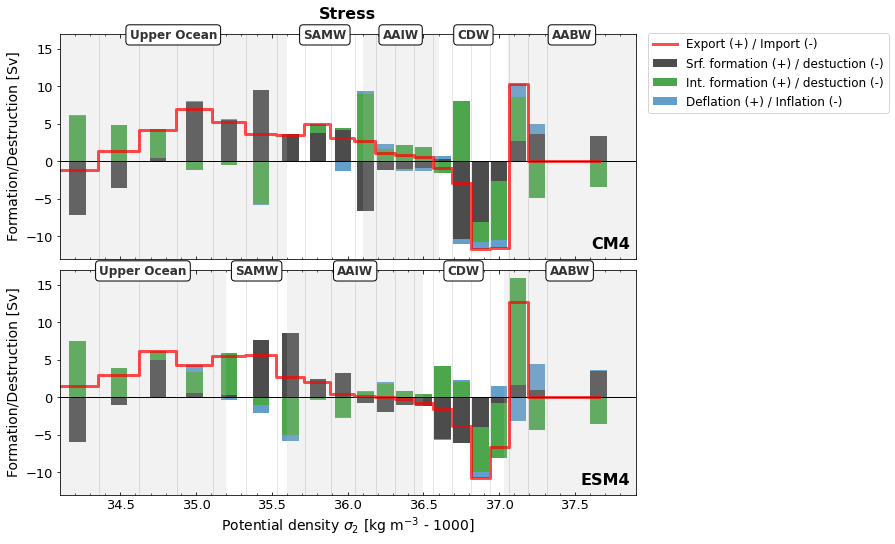

In [33]:
exp = 'stress'

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(10,8))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9,hspace = 0.05)

for i, mod in enumerate(ddict):
    
    if exp=='control':
        ti = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
        tf = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
    else:
        ti = texp[0]
        tf = texp[1]
    
    psi = tsdict[mod][exp]['psi'].sel(time=slice(ti,tf)).mean('time')
    M = tsdict[mod][exp]['dVdt'].sel(time=slice(ti,tf)).mean('time')
    G_interp = tsdict[mod][exp]['swmt'].sel(time=slice(ti,tf)).mean('time')
    
    dpsi = -1.*psi.diff('sigma2',label='lower')
    dpsi['sigma2'] = rho2_l-1000
    
    dG = -1.*G_interp.diff('sigma2',label='lower')
    dG['sigma2'] = rho2_l-1000
    
    dM = -1.*M.diff('sigma2',label='lower')
    dM['sigma2'] = rho2_l-1000
    
    D = M + psi - G_interp
    dD = -1.*D.diff('sigma2',label='lower')
    dD['sigma2'] = rho2_l-1000
    
    #dpsi = -1.*(M+psi).diff('sigma2',label='lower')
    #dpsi['sigma2'] = rho2_l-1000
    
    ds = dpsi.reset_coords(drop=True).to_dataset(name='psi') if exp=='control' \
            else dpsi.mean('mem').reset_coords(drop=True).to_dataset(name='psi')
    ds['wmt'] = dG.reset_coords(drop=True) if exp=='control' else dG.mean('mem').reset_coords(drop=True)
    ds['lvc'] = -1.*dM.reset_coords(drop=True) if exp=='control' else -1.*dM.mean('mem').reset_coords(drop=True)
    ds['mix'] = dD.reset_coords(drop=True) if exp=='control' else dD.mean('mem').reset_coords(drop=True)
    df = ds.to_dataframe()
    
    axs[i].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
    for val in rho2_i:
        axs[i].axvline(x=val-1000,c='k',lw=1,alpha=0.1)
        
    for term in [df[df>0].fillna(0),df[df<0].fillna(0)]:
        p1 = axs[i].bar(term.index, term.wmt, bar_width, align='center', alpha=0.7, color='k', bottom=0)
        p2 = axs[i].bar(term.index, term.mix, bar_width, align='center', alpha=0.7, color='g', bottom=term.wmt)
        p3 = axs[i].bar(term.index, term.lvc, bar_width, align='center', alpha=0.7, color='tab:blue',
                        bottom=term.wmt+term.mix)
        
    p4 = axs[i].step(df.index, df.psi, where='mid', c='r', lw=3, ls='-',alpha=0.7,label='Export (+) / Import (-)')
    #p4 = axs[i].step(df.index, df.psi, where='mid', c='m', lw=3, ls='-',alpha=0.7,label='Total')
    
    p1.set_label('Srf. formation (+) / destuction (-)')
    p2.set_label('Int. formation (+) / destuction (-)')
    p3.set_label('Deflation (+) / Inflation (-)')
    
    #axs[i].set_ylim([-20, 23] if mod=='CM4' else [-13, 13]) # Antwater
    axs[i].set_ylim([-13, 17]) # Stress
    #axs[i].set_yticks(np.arange(-20,25,5) if mod=='CM4' else np.arange(-10,15,5))
    axs[i].set_xlim([34.1,37.9])
    axs[i].set_xticks(np.arange(34.2,38,0.1), minor=True)
    axs[i].tick_params(axis='both', which='major', labelsize=13)
    axs[i].set_ylabel('Formation/Destruction [Sv]',fontsize=14)
    axs[i].xaxis.set_tick_params(top=True,direction='in')
    axs[i].tick_params(axis='x', which='minor', top=True,direction='in')
    
    if add_wm:
        xlimit = axs[i].get_xlim()
        ylimit = axs[i].get_ylim()
        for widx, wm in enumerate(ddict_wm[mod]['water_mass']):
            xy = (xlimit[0],ylimit[0]) if widx==0 else (ddict_wm[mod]['sig2'][widx-1],ylimit[0])
            rwidth = ddict_wm[mod]['sig2'][widx]-xlimit[0] if widx==0 \
                        else ddict_wm[mod]['sig2'][widx]-ddict_wm[mod]['sig2'][widx-1] \
                        if (widx>0) & (widx<len(ddict_wm[mod]['water_mass'])-1) \
                        else xlimit[1]-ddict_wm[mod]['sig2'][widx-1]
            rect = axs[i].add_patch(plt.Rectangle(xy,rwidth, abs(ylimit[1]-ylimit[0]),facecolor='silver',
                                                  clip_on=False, linewidth = 0,alpha=0.2 if widx%2==0 else 0.0))
            axs[i].text(xy[0]+rwidth/2, ylimit[1]-1, ddict_wm[mod]['water_mass'][widx], fontsize=12, 
                        fontweight='bold',ha='center', va='bottom',color='k',alpha=0.8,
                        bbox=dict(boxstyle="round",ec='k',fc='w'))
            
    axs[i].text(0.99, 0.03, mod, ha='right', va='bottom', fontsize=16, fontweight='bold',
                transform=axs[i].transAxes)

leg1 = axs[0].legend(fontsize=12, loc='upper right', frameon=True, fancybox=True,  ncol=1,
                     bbox_to_anchor=(1.45, 1.03))
axs[1].set_xlabel(r'Potential density $\sigma_2$ [kg m$^{-3}$ - 1000]',fontsize=14)
axs[0].set_xticklabels([])
axs[0].set_title(exp.capitalize(),fontsize=16, y=1.0, pad=15,fontweight='bold')

plt.show()

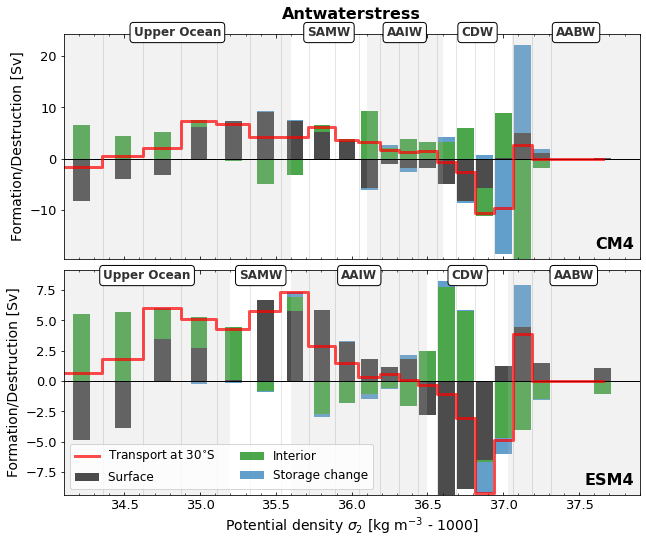